# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [1]:
m=1;
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Rf=1.0;

dx=Rf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m #100.0*2^m*10 NEW: LET'S TRY THIS *10 TO SEE IF WE HAVE THE BEHAVIOUR WE WANT
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.08


In [2]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2))

dx =0.001
dt =0.0004
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2*3) = 0.625


In [19]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [20]:
println(dx)
println(dt)

0.001
0.0004


In [21]:
epsilon=1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

1

# Grid

In [22]:
ori=0.0;
R1 = nothing
R1=range(ori, stop=Rf, step=dx);

println(size(R1))
println(R1)

(1001,)
0.0:0.001:1.0


In [23]:
print(dx)
#R = range(ori-2.0*dx, stop=Rf+2.0*dx, step=dx);
R = range(round(ori-3.0*dx,digits=10), stop=Rf+3.0*dx, step=dx)

L=length(R);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)
println(size(T))
println(size(R))

println(R[L-3])
println(L)

0.001step size is  0.001
the time step is 0.0004
(200,)
(1007,)
1.0
1007


In [24]:
include("./ScalarField.jl");

In [25]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [26]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar];



#PSI BAR

#psibar0=1
c=0.35#0.45
sigma=0.01#0.2#0.1
Amp=0.0001#0.005#0.05
"c=0.35*40
sigma=0.1*40
Amp=0.05*40"
initpsibar[4:L-3] = scalar_spaceder(R1)
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

#PSI FROM PSI,X
interp = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())
psi0=0
SFconstraint_psi_new(psi0,R1) = interp.(R1)
initpsi = rungekutta4(SFconstraint_psi_new,psi0,R)
state_array[:,3]=initpsi;
state_array=ghost(state_array);

#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,R1,0)
state_array[:,2]=initbeta;

#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,R1,0)
state_array[:,1]=initm;
state_array=ghost(state_array);

# Defining the initial state array for the evolution m β Ψ and Ψ,x

just debugging

In [27]:
"int(x) = floor(Int, x)
print(int.([0.2 1.9]))

a=R1/dx
println(a[3])
println((R1/dx)[3])
println(state_array[int((R1/dx)[1])+1,4])
println(state_array[int((R1[1]/dx+1)),4])
println(state_array[1,4])

println(state_array[int.(R1./dx.+1),4])
println(state_array[:,4])"

"int(x) = floor(Int, x)\nprint(int.([0.2 1.9]))\n\na=R1/dx\nprintln(a[3])\nprintln((R1/dx)[3])\nprintln(state_array[int((R1/dx)[1])+1,4])\nprintln(state_array[int((R1[1]/dx+1)),4])\nprintln(state_array[1,4])\n\nprintln(state_array[int.(R1./dx.+1),4])\nprintln(state_array[:,4])"

In [28]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

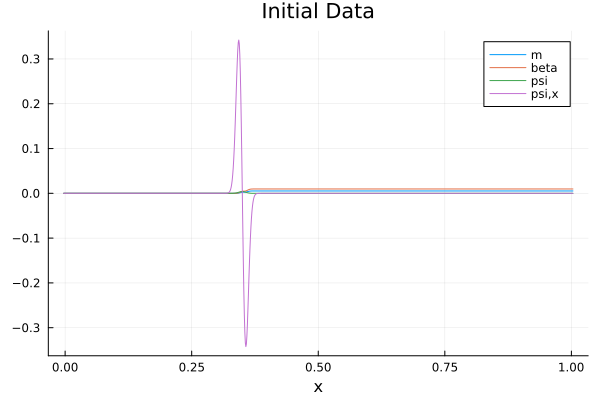

In [29]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, state_array, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

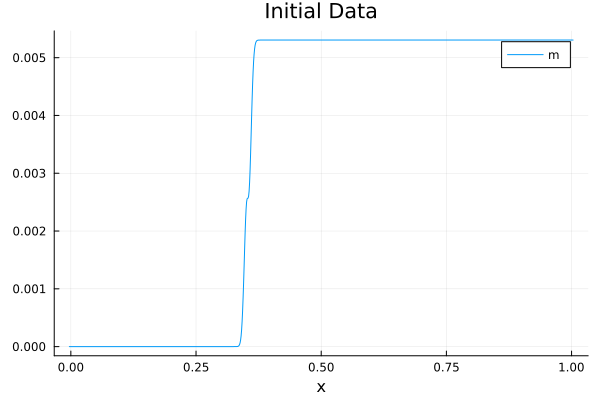

In [30]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, state_array[:,1], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

 ## Time evolution

In [31]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)
    
    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0) #evolve psi,x
    state_array=ghost(state_array)
    
    #calculate psi from psi,x
    interp = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())

    psi0=0
    SFconstraint_psi_new(psi0,R1) = interp.(R1)

    state_array[:,3] = rungekutta4(SFconstraint_psi_new,psi0,R)
    state_array=ghost(state_array)
    
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,R1,T)
    
    state_array=ghost(state_array)
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,R1,T)
    
    state_array=ghost(state_array)
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


In [32]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

## Movie of the evolution

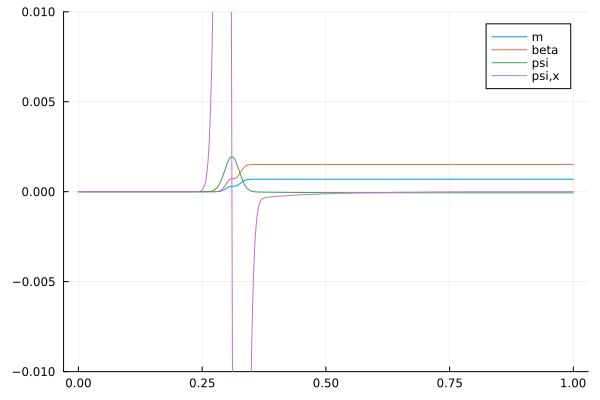

┌ Info: Saved animation to 
│   fn = /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif
└ @ Plots /home/rita13santos/.julia/packages/Plots/fw4rv/src/animation.jl:156


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
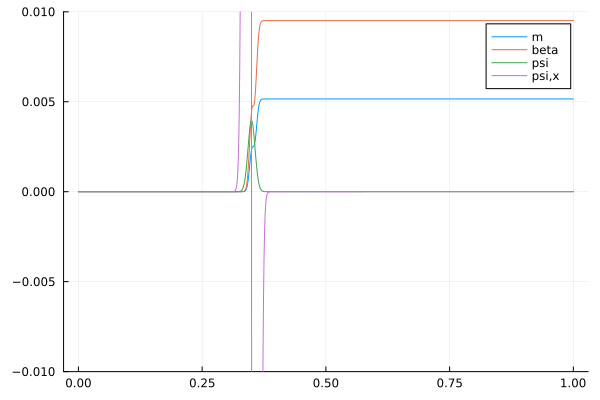

In [33]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:1:length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(R1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.01, 0.01]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)

# Interpolation

In [77]:
N=3
x=zeros(N);
y=zeros(N);

x=[1.1, 2.8, 4.7]
x1=[1.1, 2.8, 4.8]
y=[1.5, 4.3, 16.1]

data=[x y];


using Interpolations
data[:,1]=x
data[:,2]=y
itp = cubic_spline_interpolation(10:12, 10:12,  extrapolation_bc = Line()) # create interpolation function
itp(9) # call function on input data (use itp.(x) to broadcast over input vector)

8.999999999999998

In [78]:
itp.([9, 8, 1])

3-element Vector{Float64}:
 8.999999999999998
 7.9999999999999964
 0.999999999999984

In [79]:
itp2 = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())
itp2.(R)

207-element Vector{Float64}:
 -2.2492802065157096e-5
 -1.49952013767714e-5
 -7.4976006883857e-6
 -4.235164736271502e-22
  7.689629700730104e-6
  1.6552824829107725e-5
  2.7892775217897982e-5
  4.327954001763802e-5
  6.470230120446899e-5
  9.474349404271483e-5
  0.00013678076996669706
  0.00019522129280422345
  0.0002757706956599848
  ⋮
 -2.01566457731864e-39
 -5.719520396176462e-40
 -1.6084935678107224e-40
 -4.483299003815029e-41
 -1.238497196306582e-41
 -3.3908734463825724e-42
 -9.201267173992415e-43
 -2.4745912801619788e-43
 -6.595980413957055e-44
  4.924866297391118e-44
  1.644571300873888e-43
  2.7966559720087055e-43

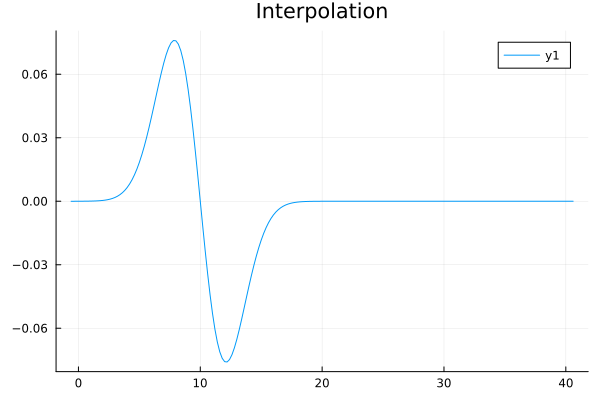

In [80]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, itp2.(R),title="Interpolation")

In [81]:
psi0=0
SFconstraint_psi_new(psi0,R1) = itp2.(R1)

integration = rungekutta4(SFconstraint_psi_new,psi0,R1)

201-element Vector{Float64}:
  0.0
  7.593615194557902e-7
  3.153733052908858e-6
  7.544874151946501e-6
  1.4579476734114407e-5
  2.5257454987628783e-5
  4.103276552659288e-5
  6.395174800239e-5
  9.683503246584859e-5
  0.00014350975614535846
  0.00020909900645941614
  0.0003003748605932674
  0.00042617989754202296
  ⋮
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6

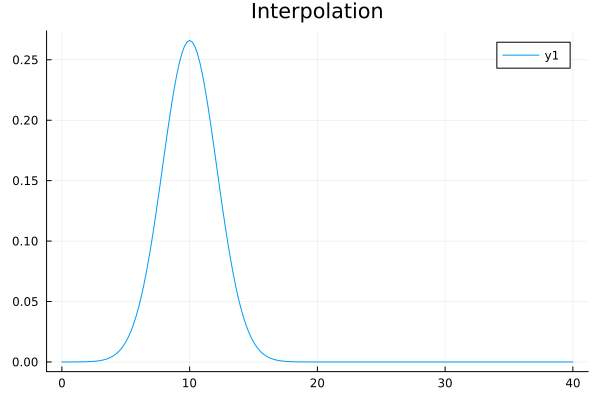

In [82]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R1, integration,title="Interpolation")